## RNN Time Series Classification

### Importing Required Libraries and Data

In [26]:
import pandas as pd
import numpy as np
#to plot the data
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#import matplotlib as mpl
#mpl.rcParams.update(mpl.rcParamsDefault)
import time
import os
os.chdir("/Users/tomxu/Documents/NASA-Jet-Engine-Maintenance/Data/CMaps/")
from sklearn.preprocessing import MinMaxScaler #to normalize data
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.utils import class_weight
#for deep learning
import tensorflow.keras
import tensorflow.keras.backend as k
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Masking, Dropout, SimpleRNN
from tensorflow.keras.callbacks import History
from tensorflow.keras import callbacks
from tensorflow.keras.utils import to_categorical

In [27]:
def prepare_data(drop_cols = True):
    dependent_var = ['RUL']
    index_columns_names =  ["UnitNumber","Cycle"]
    operational_settings_columns_names = ["OpSet"+str(i) for i in range(1,4)]
    sensor_measure_columns_names =["SensorMeasure"+str(i) for i in range(1,22)]
    input_file_column_names = index_columns_names + operational_settings_columns_names + sensor_measure_columns_names
    cols_to_drop = ['OpSet3', 'SensorMeasure1', 'SensorMeasure5', 'SensorMeasure6', 'SensorMeasure10',
                    'SensorMeasure14', 'SensorMeasure16', 'SensorMeasure18', 'SensorMeasure19']
    df_train = pd.read_csv('train_FD001.txt',delim_whitespace=True,names=input_file_column_names)
    rul = pd.DataFrame(df_train.groupby('UnitNumber')['Cycle'].max()).reset_index()
    rul.columns = ['UnitNumber', 'max']
    df_train = df_train.merge(rul, on=['UnitNumber'], how='left')
    df_train['RUL'] = df_train['max'] - df_train['Cycle']
    df_train.drop('max', axis=1, inplace=True)
    df_train['failure_lbl_1'] = [1 if i < 50 else 0 for i in df_train.RUL]
    df_train['failure_lbl_2'] = df_train['failure_lbl_1']
    df_train['failure_lbl_2'] = np.where(df_train.RUL < 25, 2, df_train['failure_lbl_2'])
    df_test = pd.read_csv('test_FD001.txt', delim_whitespace=True, names=input_file_column_names)    
    if(drop_cols == True):
        df_train = df_train.drop(cols_to_drop, axis = 1)
        df_test = df_test.drop(cols_to_drop, axis = 1)
    y_true = pd.read_csv('RUL_FD001.txt', delim_whitespace=True,names=["RUL"])
    y_true["UnitNumber"] = y_true.index
    y_true['failure_lbl_1'] = [1 if i < 50 else 0 for i in y_true.RUL]
    y_true['failure_lbl_2'] = y_true['failure_lbl_1']
    y_true['failure_lbl_2'] = np.where(y_true.RUL < 25, 2, y_true['failure_lbl_2'])    
    return df_train, df_test, y_true

In [28]:
df_train, df_test, y_true = prepare_data(drop_cols=True)
df_train.shape, df_test.shape, y_true.shape

((20631, 20), (13096, 17), (100, 4))

In [29]:
feats = df_train.columns.drop(['UnitNumber', 'Cycle', 'RUL', 'failure_lbl_1', 'failure_lbl_2'])

In [30]:
min_max_scaler = MinMaxScaler(feature_range=(-1,1))
df_train[feats] = min_max_scaler.fit_transform(df_train[feats])
df_test[feats] = min_max_scaler.transform(df_test[feats])

In [31]:
df_train.head()

,UnitNumber,Cycle,OpSet1,OpSet2,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure7,SensorMeasure8,SensorMeasure9,SensorMeasure11,SensorMeasure12,SensorMeasure13,SensorMeasure15,SensorMeasure17,SensorMeasure20,SensorMeasure21,RUL,failure_lbl_1,failure_lbl_2
0,1,1,-0.080460,-0.666667,-0.632530,-0.186396,-0.380486,0.452496,-0.515152,-0.780490,-0.261905,0.266525,-0.588235,-0.272028,-0.333333,0.426357,0.449323,191,0,0
1,1,2,0.218391,-0.500000,-0.433735,-0.093961,-0.294733,0.256039,-0.575758,-0.799515,-0.238095,0.530917,-0.441176,-0.177376,-0.333333,0.333333,0.462027,190,0,0
2,1,3,-0.494253,0.500000,-0.313253,-0.260955,-0.258947,0.420290,-0.454545,-0.719914,-0.500000,0.590618,-0.558824,-0.285110,-0.666667,0.255814,0.242751,189,0,0
3,1,4,0.080460,0.000000,-0.313253,-0.487683,-0.337610,0.481481,-0.363636,-0.750965,-0.666667,0.778252,-0.411765,-0.666795,-0.333333,0.147287,0.324772,188,0,0
4,1,5,-0.218391,-0.333333,-0.301205,-0.485066,-0.190749,0.336554,-0.515152,-0.700081,-0.488095,0.492537,-0.529412,-0.195845,-0.166667,0.178295,0.409003,187,0,0


In [32]:
df_test.head()

,UnitNumber,Cycle,OpSet1,OpSet2,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure7,SensorMeasure8,SensorMeasure9,SensorMeasure11,SensorMeasure12,SensorMeasure13,SensorMeasure15,SensorMeasure17,SensorMeasure20,SensorMeasure21
0,1,1,0.264368,0.500000,0.090361,-0.378679,-0.461175,0.304348,-0.575758,-0.744773,-0.583333,0.292111,-0.558824,-0.382070,-0.333333,0.116279,0.323667
1,1,2,-0.310345,-0.500000,-0.698795,-0.240898,-0.555368,0.610306,-0.666667,-0.706632,-0.226190,0.479744,-0.470588,-0.573682,-0.166667,0.364341,0.373654
2,1,3,0.034483,0.166667,-0.246988,-0.306736,-0.355503,0.371981,-0.545455,-0.683837,-0.226190,0.398721,-0.558824,-0.082724,-0.166667,0.457364,0.442695
3,1,4,0.482759,0.000000,-0.259036,-0.429693,-0.183997,0.359098,-0.606061,-0.788567,-0.488095,0.147122,-0.500000,-0.485956,-0.500000,0.333333,0.324220
4,1,5,0.160920,0.000000,-0.216867,-0.295836,-0.335922,0.388084,-0.666667,-0.795208,-0.452381,0.475480,-0.558824,-0.398230,-0.666667,0.317829,0.432753


In [33]:
y_true.head()

,RUL,UnitNumber,failure_lbl_1,failure_lbl_2
0,112,0,0,0
1,98,1,0,0
2,69,2,0,0
3,82,3,0,0
4,91,4,0,0



LSTM expects an input in the shape of a numpy array of 3 dimensions and I will need to convert train and test data accordingly.

In [34]:
def gen_train(id_df, seq_length, seq_cols):
    """
        function to prepare train data into (samples, time steps, features)
        id_df = train dataframe
        seq_length = look back period
        seq_cols = feature columns
    """        
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]    
    for start, stop in zip(range(0, num_elements-seq_length+1), range(seq_length, num_elements+1)):
        lstm_array.append(data_array[start:stop, :])    
    return np.array(lstm_array)

In [35]:
def gen_target(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length-1:num_elements+1]

In [36]:
def gen_test(id_df, seq_length, seq_cols, mask_value):
    """
        function to prepare test data into (samples, time steps, features)
        function only returns last sequence of data for every unit
        id_df = test dataframe
        seq_length = look back period
        seq_cols = feature columns
    """
    df_mask = pd.DataFrame(np.zeros((seq_length-1,id_df.shape[1])),columns=id_df.columns)
    df_mask[:] = mask_value    
    id_df1 = pd.concat([df_mask, id_df],ignore_index=True)    
    data_array = id_df1[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]    
    start = num_elements-seq_length
    stop = num_elements    
    lstm_array.append(data_array[start:stop, :])    
    return np.array(lstm_array)

### Function to Print results

In [37]:
def print_results(y_test, y_pred, multi_class = False):    
    #f1-score
    if multi_class == True:
        f1 = f1_score(y_test, y_pred, average="macro")
    else:
        f1 = f1_score(y_test, y_pred)
    print("F1 Score: ", f1)
    print(classification_report(y_test, y_pred))    
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(12,12))
    plt.subplot(221)
    sns.heatmap(conf_matrix, fmt = "d", annot=True, cmap='Blues')
    b, t = plt.ylim()
    plt.ylim(b + 0.5, t - 0.5)
    plt.title('Confuion Matrix')
    plt.ylabel('True Values')
    plt.xlabel('Predicted Values')
    #roc_auc_score
    if multi_class == False:
        model_roc_auc = roc_auc_score(y_test, y_pred) 
        print ("Area under curve : ",model_roc_auc, "\n")
        fpr,tpr,thresholds = roc_curve(y_test, y_pred)
        gmeans = np.sqrt(tpr * (1-fpr))
        ix = np.argmax(gmeans)
        threshold = np.round(thresholds[ix],3)
        plt.subplot(222)
        plt.plot(fpr, tpr, color='darkorange', lw=1, label = "Auc : %.3f" %model_roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best Threshold:' + str(threshold))
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic')
        plt.legend(loc="lower right")

## Binary Classification

In [38]:
sequence_length = 50
mask_value = 0
label = "failure_lbl_1"


Let's prepare data using above functions.

In [39]:
#generate train
x_train=np.concatenate(list(list(gen_train(df_train[df_train['UnitNumber']==unit], sequence_length, feats)) for unit in df_train['UnitNumber'].unique()))
print(x_train.shape)

(15731, 50, 15)


In [40]:
#generate target of train
y_train = np.concatenate(list(list(gen_target(df_train[df_train['UnitNumber']==unit], sequence_length, label)) for unit in df_train['UnitNumber'].unique()))
y_train.shape

(15731,)

In [41]:
#generate test
x_test=np.concatenate(list(list(gen_test(df_test[df_test['UnitNumber']==unit], sequence_length, feats, mask_value)) for unit in df_test['UnitNumber'].unique()))
print(x_test.shape)

(100, 50, 15)


In [42]:
#true target of test 
y_test = y_true.RUL.values
y_test.shape

(100,)

In [43]:
nb_features = x_train.shape[2]
nb_out = 1

In [44]:
nb_features

15

In [45]:
cls_wt= class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
cls_wt = {i : cls_wt[i] for i in range(2)}
cls_wt

{0: 0.617822637656115, 1: 2.6218333333333335}

### Model

In [25]:
history = History()
model = Sequential()
model.add(SimpleRNN(100, input_shape=(sequence_length, nb_features), activation = 'relu'))
model.add(Dense(50, activation = 'relu'))
model.add(Dense(units=nb_out, activation='sigmoid'))
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 100)               11600     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 16,701
Trainable params: 16,701
Non-trainable params: 0
_________________________________________________________________


In [46]:
%%time
# fit the model
model.fit(x_train, y_train, epochs=100, batch_size=64, validation_split=0.2, verbose=1, class_weight=cls_wt,
          callbacks=[history, callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')])

Epoch 1/100


2022-11-24 21:27:13.147662: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


197/197 [==============================] - ETA: 0s - loss: 0.1745 - accuracy: 0.9194

2022-11-24 21:29:44.285260: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


197/197 [==============================] - 156s 792ms/step - loss: 0.1745 - accuracy: 0.9194 - val_loss: 0.2350 - val_accuracy: 0.9091
Epoch 2/100
197/197 [==============================] - 156s 791ms/step - loss: 0.1291 - accuracy: 0.9379 - val_loss: 0.1570 - val_accuracy: 0.9355
Epoch 3/100
197/197 [==============================] - 158s 803ms/step - loss: 0.1234 - accuracy: 0.9398 - val_loss: 0.1988 - val_accuracy: 0.9215
Epoch 4/100
197/197 [==============================] - 169s 857ms/step - loss: 0.1108 - accuracy: 0.9487 - val_loss: 0.1643 - val_accuracy: 0.9358
Epoch 5/100
197/197 [==============================] - 160s 811ms/step - loss: 0.1021 - accuracy: 0.9552 - val_loss: 0.1626 - val_accuracy: 0.9317
Epoch 6/100
197/197 [==============================] - 158s 805ms/step - loss: 0.0802 - accuracy: 0.9665 - val_loss: 0.1456 - val_accuracy: 0.9403
Epoch 7/100
197/197 [==============================] - 159s 809ms/step - loss: 0.0834 - accuracy: 0.9638 - val_loss: 0.1076 - val_

Text(0.5, 1.0, 'Loss')

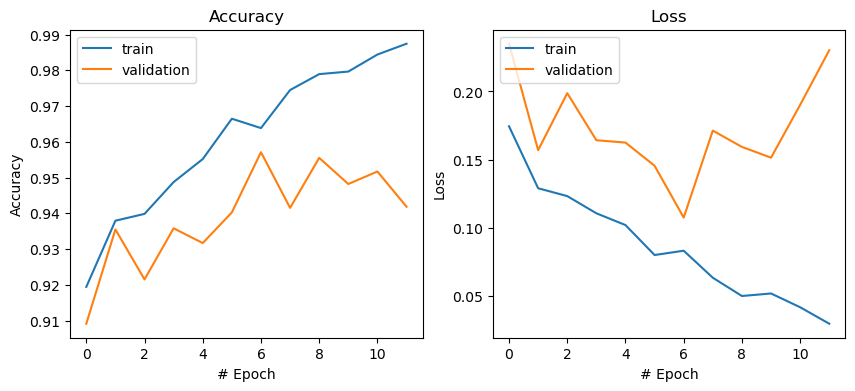

In [47]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))
# Accuracy
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('# Epoch')
ax[0].legend(['train', 'validation'], loc='upper left')
ax[0].set_title('Accuracy')
# Loss
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('# Epoch')
ax[1].legend(['train', 'validation'], loc='upper left')
ax[1].set_title('Loss')

2022-11-24 22:15:40.279259: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


F1 Score:  0.7499999999999999
              precision    recall  f1-score   support

           0       0.88      1.00      0.94        75
           1       1.00      0.60      0.75        25

    accuracy                           0.90       100
   macro avg       0.94      0.80      0.84       100
weighted avg       0.91      0.90      0.89       100

Area under curve :  0.8 



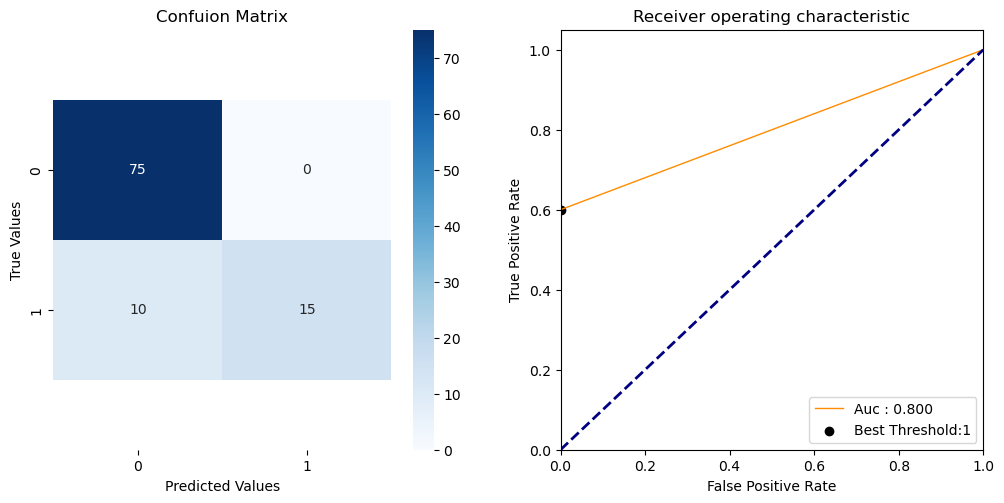

In [48]:
y_pred = (model.predict(x_test) > 0.5).astype("int32")
print_results(y_true.failure_lbl_1, y_pred)

In [24]:
confusion_matrix(y_train, (model.predict(x_train) > 0.5).astype("int32"))

array([[12063,   668],
       [   20,  2980]])

## Multiclass Classification

In [27]:
sequence_length = 50
mask_value = 0
label = "failure_lbl_2"


Let's prepare data using above functions.

In [28]:
#generate train
x_train=np.concatenate(list(list(gen_train(df_train[df_train['UnitNumber']==unit], sequence_length, feats)) for unit in df_train['UnitNumber'].unique()))
print(x_train.shape)

(15731, 50, 15)


In [29]:
#generate target of train
y_train = np.concatenate(list(list(gen_target(df_train[df_train['UnitNumber']==unit], sequence_length, label)) for unit in df_train['UnitNumber'].unique()))
y_train.shape

(15731,)

In [30]:
y_train2 = to_categorical(y_train)
y_train2

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [31]:
#generate test
x_test=np.concatenate(list(list(gen_test(df_test[df_test['UnitNumber']==unit], sequence_length, feats, mask_value)) for unit in df_test['UnitNumber'].unique()))
print(x_test.shape)

(100, 50, 15)


In [32]:
nb_features = x_train.shape[2]
nb_out = y_train2.shape[1]

In [33]:
nb_features, nb_out

15

In [34]:
cls_wt= class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
cls_wt = {i : cls_wt[i] for i in range(3)}
cls_wt

{0: 0.48864660019258843, 1: 2.0974666666666666, 2: 2.0974666666666666}

### Model

In [35]:
history2 = History()
model2 = Sequential()
model2.add(SimpleRNN(100, input_shape=(sequence_length, nb_features), activation = 'relu'))
model2.add(Dense(50, activation = 'relu'))
model2.add(Dense(units=nb_out, activation='softmax'))
model2.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 16)                512       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 27        
Total params: 675
Trainable params: 675
Non-trainable params: 0
_________________________________________________________________


In [36]:
%%time
# fit the model
model2.fit(x_train, y_train2, epochs=10, batch_size=64, validation_split=0.2, verbose=1, class_weight = cls_wt,
           callbacks = [history2, callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')])

Epoch 1/10


2022-10-05 19:06:57.167142: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


197/197 [==============================] - ETA: 0s - loss: 0.7850 - accuracy: 0.7982

2022-10-05 19:09:23.482515: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


197/197 [==============================] - 152s 771ms/step - loss: 0.7850 - accuracy: 0.7982 - val_loss: 0.4542 - val_accuracy: 0.8227
Epoch 2/10
197/197 [==============================] - 163s 826ms/step - loss: 0.4442 - accuracy: 0.8331 - val_loss: 0.3986 - val_accuracy: 0.8313
Epoch 3/10
197/197 [==============================] - 165s 836ms/step - loss: 0.4043 - accuracy: 0.8446 - val_loss: 0.3940 - val_accuracy: 0.8316
Epoch 4/10
197/197 [==============================] - 166s 842ms/step - loss: 0.3893 - accuracy: 0.8516 - val_loss: 0.4108 - val_accuracy: 0.8338
Epoch 5/10
197/197 [==============================] - 168s 852ms/step - loss: 0.3781 - accuracy: 0.8505 - val_loss: 0.4066 - val_accuracy: 0.8360
Epoch 6/10
197/197 [==============================] - 171s 867ms/step - loss: 0.3641 - accuracy: 0.8540 - val_loss: 0.3834 - val_accuracy: 0.8433
Epoch 7/10
197/197 [==============================] - 165s 836ms/step - loss: 0.3584 - accuracy: 0.8584 - val_loss: 0.3676 - val_accura

Text(0.5, 1.0, 'Loss')

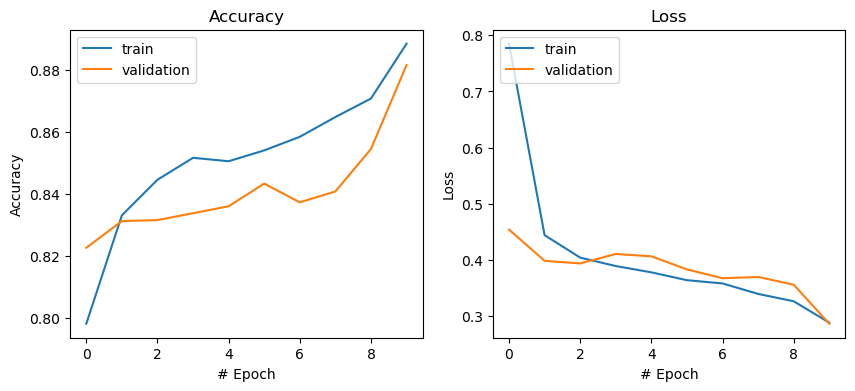

In [37]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))
# Accuracy
ax[0].plot(history2.history['accuracy'])
ax[0].plot(history2.history['val_accuracy'])
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('# Epoch')
ax[0].legend(['train', 'validation'], loc='upper left')
ax[0].set_title('Accuracy')
# Loss
ax[1].plot(history2.history['loss'])
ax[1].plot(history2.history['val_loss'])
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('# Epoch')
ax[1].legend(['train', 'validation'], loc='upper left')
ax[1].set_title('Loss')

2022-10-05 19:41:22.426899: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


F1 Score:  0.7923194796259813
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        70
           1       0.45      0.91      0.61        11
           2       0.93      0.74      0.82        19

    accuracy                           0.87       100
   macro avg       0.80      0.85      0.79       100
weighted avg       0.93      0.87      0.89       100



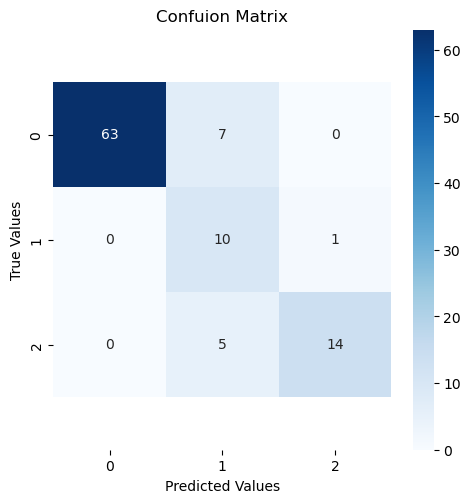

In [38]:
y_pred = np.argmax(model2.predict(x_test), axis=-1)
print_results(y_true.failure_lbl_2, y_pred, multi_class=True)

In [39]:
confusion_matrix(y_train, np.argmax(model2.predict(x_train), axis=-1))

array([[9666, 1065,    0],
       [ 207, 2210,   83],
       [   0,  296, 2204]])